In [119]:
%pip install rdkit
%cd /content/drive/MyDrive/Github/Machine_Learning_personal_learning/

/content/drive/MyDrive/Github/Machine_Learning_personal_learning


Using a research article (by John S. Delaney - J. Chem. Inf. Comput. Sci. 2004, 44, 3, 1000-1005.) by applying Linear Regression to predict the solubility of molecules (i.e. solubility of drugs is an important physicochemical property in Drug discovery, design and development).

In [160]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem, Draw, rdFMCS
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import copy
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf

In [121]:
# Importing the dataset
data = pd.read_csv("../../ML_datasets/Delaney_datasets/Delaney_dataset.txt")

In [122]:
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [123]:
# Converting molecules from SMILES String to an rdkit object
mol = [Chem.MolFromSmiles(i) for i in data.SMILES]

In [124]:
# Calculate molecular descriptors
descrp_col_names = ["MOLWt", "MolLogP", "NumRotBonds", "AromaticProp"]
descrp_MolWt = [Descriptors.MolWt(i) for i in mol]
descrp_MolLogP = [Descriptors.MolLogP(i) for i in mol]
descrp_NumRotBonds = [Descriptors.NumRotatableBonds(i) for i in mol]
aromatic_atoms = [[i.GetAtomWithIdx(j).GetIsAromatic() for j in range(i.GetNumAtoms())] for i in mol]
sum_aromatic_atoms = [sum(i) for i in aromatic_atoms]
heavy_atoms = [Descriptors.HeavyAtomCount(i) for i in mol]
descrp_AromaticProp = [i/j for i,j in zip(sum_aromatic_atoms, heavy_atoms)]
# creating a pandas dataframe of descriptors
descrp_df = pd.DataFrame(np.array([descrp_MolWt, descrp_MolLogP, descrp_NumRotBonds, descrp_AromaticProp]).T, columns = descrp_col_names)
descrp_df.head()

,MOLWt,MolLogP,NumRotBonds,AromaticProp
0,167.850,2.5954,0.0,0.0
1,133.405,2.3765,0.0,0.0
2,167.850,2.5938,1.0,0.0
3,133.405,2.0289,1.0,0.0
4,187.375,2.9189,1.0,0.0


In [125]:
# Assigning X and Y
X = descrp_df
Y = data.iloc[:, 1]

In [126]:
# preprocessing the X data by applying min-max norm
X = (X - X.min())/(X.max() - X.min())
#X.describe()

# splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 24)

# printing...
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (915, 4), (915,)
Test: (229, 4), (229,)


In [127]:
# Linear regression model with MSE and r2 scores as metrics
model = linear_model.LinearRegression()
# training the model
model.fit(X_train, y_train)

LinearRegression()

In [128]:
# predicting y_train
y_tr_pred = model.predict(X_train)
# computing MSE and r2 score
tr_mse = mean_squared_error(y_train, y_tr_pred)
tr_r2 = r2_score(y_train, y_tr_pred)
tr_mse, tr_r2

(0.985255619913687, 0.7774672387512662)

In [129]:
# predicting y_test
y_ts_pred = model.predict(X_test)
# computing MSE and r2 score
ts_mse = mean_squared_error(y_test, y_ts_pred)
ts_r2 = r2_score(y_test, y_ts_pred)
ts_mse, ts_r2

(1.1234947263991966, 0.7324200963605263)

In [130]:
model.coef_, model.intercept_

(array([ -5.4747042 , -12.85249769,   0.20891181,  -0.48929741]),
 5.618331382378262)

In [131]:
# plotting parity plots between y_test and y_ts_pred
fig = px.scatter(x = y_test, y = y_ts_pred, labels = {"x": "y_test", "y": "y_ts_pred"})
fig.update_layout(title = "Parity Plot")
fig.add_shape(type = "line", line = dict(dash = "dash"), x0 = y_test.min(), y0 = y_test.min(), x1 = y_test.max(), y1 = y_test.max())
fig.show()


use other models: simple Neural Networks, RFs, XGBoost

Below I have tried some built in functions of RDKIT

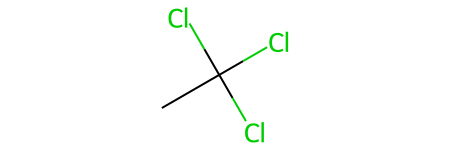

In [132]:
# Playing with molecular fingerprints using RDKIT
mol[1]

In [133]:
# Getting molecule properties
print(f"Num of atoms = {mol[1].GetNumAtoms()}")
print(f"Num of bonds = {mol[1].GetNumBonds()}")
print(f"Num of conformers = {mol[1].GetNumConformers()}")

Num of atoms = 5
Num of bonds = 4
Num of conformers = 0


In [134]:
#Converting to 3D and computing energy
k = copy.deepcopy(mol[1])
k = Chem.AddHs(k)
AllChem.EmbedMultipleConfs(k, numConfs = 12)
res = AllChem.MMFFOptimizeMoleculeConfs(k, maxIters = 1000) # utilizes MMFF94 to optimize

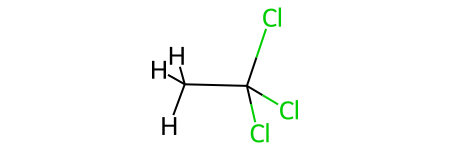

In [135]:
k

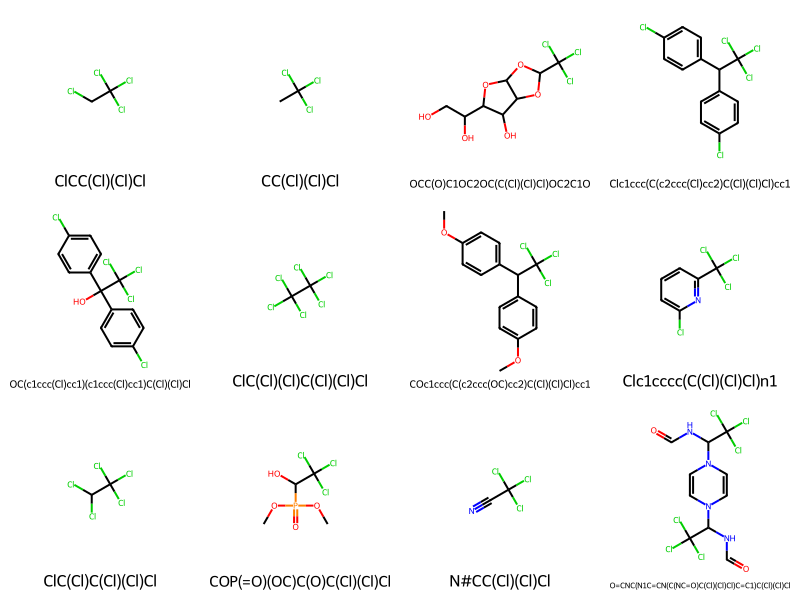

In [136]:
# Checking if substructure of mol[1] is present in other molecules and displaying them
subms = [x for x in mol if x.HasSubstructMatch(mol[1])]
AllChem.Compute2DCoords(mol[1])
for m in subms:
  _ = AllChem.GenerateDepictionMatching2DStructure(m,mol[1])
display(Draw.MolsToGridImage(subms,molsPerRow=4,subImgSize=(200,200), legends=[Chem.MolToSmiles(i) for i in subms]))

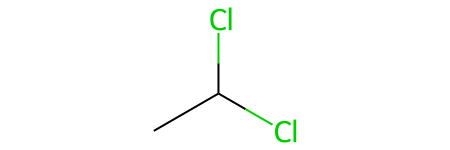

In [137]:
# Finding maximum commmon substructure (MCS)
c = [mol[0], mol[1], mol[2]]
mcs = rdFMCS.FindMCS(c)
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
mcs_mol

In [138]:
# Fingerprinting and Molecular similarity
fpgen = AllChem.GetRDKitFPGenerator() # topological fingerprint
fps = [fpgen.GetFingerprint(i) for i in mol]

In [139]:
DataStructs.TanimotoSimilarity(fps[0], fps[1])

0.7

In [140]:
DataStructs.DiceSimilarity(fps[0], fps[1])

0.8235294117647058

In [141]:
fpgenmo = AllChem.GetMorganGenerator(radius=2) # Morgan (circular) fingerprint
fpsmo = [fpgen.GetFingerprint(i) for i in mol]

In [142]:
lb = len(fpsmo[0]) # each fingerbrint is of length 2048 bits
# getting additional information
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fpsmo2 = [fpgenmo.GetSparseFingerprint(i) for i in mol]

In [143]:
fp = fpgenmo.GetSparseCountFingerprint(mol[0],additionalOutput=ao)
info = ao.GetBitInfoMap()

In [144]:
info

{170894115: ((3, 1), (4, 1), (5, 1)),
 198706261: ((0, 1),),
 1016841875: ((0, 0), (3, 0), (4, 0), (5, 0)),
 2035488874: ((2, 1),),
 2151416052: ((1, 2),),
 2245277810: ((2, 0),),
 2245384272: ((1, 0),),
 2910196842: ((1, 1),)}

In [145]:
env = Chem.FindAtomEnvironmentOfRadiusN(mol[0],1,4)
amap={}
submol=Chem.PathToSubmol(mol[0],env,atomMap=amap)
submol.GetNumAtoms()
amap

{2: 0, 4: 1}

In [146]:
descr = [Descriptors.CalcMolDescriptors(i) for i in mol]
descr_df = pd.DataFrame(descr)
descr_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38,...,0,0,0,0,0,0,0,0,0,0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32,...,0,0,0,0,0,0,0,0,0,0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38,...,0,0,0,0,0,0,0,0,0,0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32,...,0,0,0,0,0,0,0,0,0,0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50,...,0,0,0,0,0,0,0,0,0,0


In [147]:
# Getting Morgan Fingerprint as a bit vector
fp1 = AllChem.GetMorganGenerator(radius = 1)
fp2 = AllChem.GetMorganGenerator(radius = 2)
fp3 = AllChem.GetMorganGenerator(radius = 3)
f1 = [fp1.GetFingerprintAsNumPy(mol[i]) for i in range(len(mol))]
f2 = [fp2.GetFingerprintAsNumPy(mol[i]) for i in range(len(mol))]
f3 = [fp3.GetFingerprintAsNumPy(mol[i]) for i in range(len(mol))]

In [148]:
# getting a pandas dataframe of the 3 fingerprints
f1 = np.array(f1)
f2 = np.array(f2)
f3 = np.array(f3)
f1_df = pd.DataFrame(f1)
f23_df = pd.DataFrame(f2)
f3_df = pd.DataFrame(f3)

So above I have 4 fingerprints: 1 descriptor based fingerprint and 3 Morgan based fingerprints with 3 radii (1,2,3)

I will use the first fingerprint

In [149]:
X = descr_df
Y = data.iloc[:, 1]

In [150]:
# Find correlations between features in X in abs scale
corr_matrix = X.corr().abs()
# print(corr_matrix["r(BVI)(Å)"], corr_matrix["μ"], corr_matrix["r(AVI)(Å)"], corr_matrix["r(AXII)(Å)"])
# corr_matrix = corr_matrix.mask(np.eye(corr_matrix.shape[0], dtype=bool))
corr_series = corr_matrix.unstack()
corr_series = corr_series.sort_values(ascending = False)
corr_series = corr_series.drop_duplicates()
print(corr_series[0:50])

# plotting correlation matrix
fig = px.imshow(corr_matrix, text_auto = True)
fig.show()

# plotting between 2 correlations
#fig = px.scatter(x = corr_matrix["r(AVI)(Å)"], y = corr_matrix["r(AXII)(Å)"], labels = {"x": "r(AVI)(Å)", "y": "r(AXII)(Å)"})
#fig.show()

MaxAbsEStateIndex       MaxAbsEStateIndex      1.000000
MolWt                   ExactMolWt             0.999979
Chi1                    HeavyAtomCount         0.998507
MolWt                   HeavyAtomMolWt         0.997738
HeavyAtomMolWt          ExactMolWt             0.997421
NumValenceElectrons     Chi0                   0.995649
HeavyAtomCount          Chi0                   0.995461
fr_phenol_noOrthoHbond  fr_phenol              0.992909
NumValenceElectrons     HeavyAtomCount         0.990439
Chi4n                   Chi3n                  0.989963
Chi1                    Chi0                   0.989907
LabuteASA               Chi0v                  0.987045
Chi1n                   Chi0n                  0.986695
Chi1                    NumValenceElectrons    0.985288
LabuteASA               MolMR                  0.984797
MaxAbsPartialCharge     MinPartialCharge       0.983691
LabuteASA               Chi0                   0.981744
SMR_VSA2                fr_nitrile             0

In [151]:
# convert corr_series to a dataframe with 3 columns, 2 columns of features and last column with correlation values
corr_df = pd.DataFrame(corr_series.index.tolist(), columns = ["Feature1", "Feature2"])
corr_df["Correlation"] = corr_series.values
corr_df = corr_df.iloc[1:]
corr_df.tail()

,Feature1,Feature2,Correlation
17998,NumAliphaticRings,SMR_VSA3,0.000014
17999,EState_VSA2,fr_ArN,0.000013
18000,SMR_VSA10,fr_nitro,0.000009
18001,fr_lactone,Kappa3,0.000007
18002,MaxAbsEStateIndex,NumRadicalElectrons,NaN


In [152]:
# remove correlations < 0.7
high_corr_feature_pairs = corr_df[corr_df["Correlation"] > 0.8]
# get a list of unique features in high_corr_feature_pairs "minimum vertex cover"
len(high_corr_feature_pairs)

261

In [153]:
# make a list of features appearing in high_corr_feature_pairs
high_corr_features = high_corr_feature_pairs["Feature1"].tolist() + high_corr_feature_pairs["Feature2"].tolist()
pairs = list(zip(high_corr_feature_pairs["Feature1"].tolist(), high_corr_feature_pairs["Feature2"].tolist()))
req = []
extra = []
for i in pairs:
  if i[0] in extra and i[1] in extra: # both are in extra
    continue
  elif i[0] in req and i[1] in req: # both are in req
    req.remove(i[1])
    if i[1] not in extra:
      extra.append(i[1])
  elif i[0] in extra and i[1] not in extra: # one feature in extra, means that some other correlated feature already in req
    if i[1] in req:
      req.remove(i[1])
      extra.append(i[1])
    else:
      extra.append(i[1])
  elif i[1] in extra and i[0] not in extra: # one feature in extra, means that some other correlated feature already in req
    if i[0] in req:
      req.remove(i[0])
      extra.append(i[0])
    else:
      extra.append(i[0])
  elif i[0] in req and i[1] not in extra: # one feature in req, other not in extra
    extra.append(i[1])
  elif i[1] in req and i[0] not in extra: # one feature in req, other not in extra
    extra.append(i[0])
  else:
    req.append(i[0])
    extra.append(i[1])
print(len(req), len(extra))

17 77


In [154]:
len(set(extra))

77

In [155]:
# drop columns in extra from X
X = X.drop(columns = extra)
X.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,NumRadicalElectrons,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan2,BCUT2D_MWLOW,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,0,0.203436,0.122063,1.333333,10.928780,...,0,0,0,0,0,0,0,0,0,0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,0,0.187382,0.084013,1.200000,10.948044,...,0,0,0,0,0,0,0,0,0,0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,0,0.137344,0.102365,0.833333,10.929605,...,0,0,0,0,0,0,0,0,0,0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,0,0.123772,0.120829,1.600000,10.949696,...,0,0,0,0,0,0,0,0,0,0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,0,0.382976,0.199489,1.000000,10.767629,...,0,0,0,0,0,0,0,0,0,0


In [172]:
# We will use stratified k-fold cross validation to train the models
# setting accuracy score as scoring metric for k-fold
def cv_scoring(estimator, X, y):
    return r2_score(y, estimator.predict(X))

# Initializing models to be used
models = {
    "SVR": SVR(),
    #"GaussianNB": GaussianNB(),
    "RandomForest": RandomForestRegressor(random_state=18),
    "GradientBoosting": GradientBoostingRegressor(random_state=18),
    "Bagging": BaggingRegressor(),
    "ExtraTrees": ExtraTreesRegressor(random_state=18),
    "KNeighbors": KNeighborsRegressor()
    }

In [173]:
# k = 5 splits
scores_k5 = []
times_k5 = []

# Producing cross validation score and runtime for the models and tabulationg them in a table
for i in models:
  model = models[i]
  cv = KFold(n_splits=5, shuffle=True, random_state=42) # k = 5 splits
  start_time = time.time()
  scores = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = cv_scoring)
  end_time = time.time()
  execution_time = end_time - start_time
  scores_k5.append(np.mean(scores))
  times_k5.append(execution_time)
  print("=="*30)
  print(i)
  print(f"Scores: {scores}")
  print(f"Mean Score: {np.mean(scores)}")
  print(f"Model training time: {execution_time} seconds")

SVR
Scores: [-0.00053327 -0.00161951 -0.0008021  -0.01676924 -0.02978629]
Mean Score: -0.009902084731076144
Model training time: 0.5922608375549316 seconds
RandomForest
Scores: [0.9021663  0.90327646 0.89968997 0.89036706 0.89367554]
Mean Score: 0.897835066791272
Model training time: 15.159242630004883 seconds
GradientBoosting
Scores: [0.91262986 0.91566607 0.90719517 0.89090429 0.90667214]
Mean Score: 0.906613504633099
Model training time: 4.827620029449463 seconds
Bagging
Scores: [0.88890765 0.89676885 0.88506228 0.87632866 0.86803766]
Mean Score: 0.883021022178751
Model training time: 2.0721628665924072 seconds
ExtraTrees
Scores: [0.91461682 0.921627   0.91454983 0.90706578 0.91125003]
Mean Score: 0.9138218940027247
Model training time: 12.376113414764404 seconds
KNeighbors
Scores: [0.51379599 0.46828576 0.53017655 0.56292094 0.48110742]
Mean Score: 0.5112573320942401
Model training time: 0.10956168174743652 seconds


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBoostRegressor
0     0.420389
1     0.635164
2     0.748491
3     0.808140
4     0.839099
5     0.858103
6     0.868776
7     0.874899
8     0.880005
9     0.882696
10    0.885100
11    0.886639
12    0.887878
13    0.889129
14    0.890033
15    0.890659
16    0.8

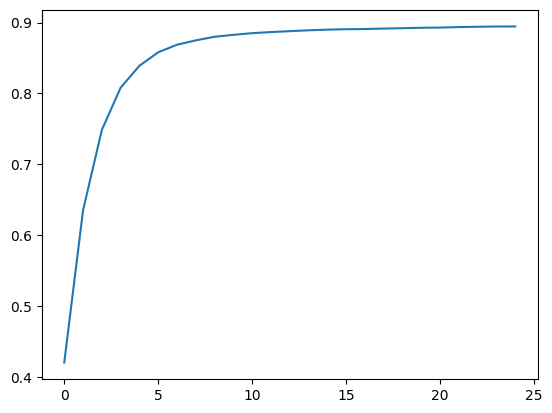

In [176]:
# for XGBoost, remember scores here outputed from xgb.cv is from every boosted rounds
def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

models["XGBoost"] = xgb.XGBRegressor(random_state=18)
start_time = time.time()
dtrain = xgb.DMatrix(X, Y)
params = models["XGBoost"].get_xgb_params()
print(params)
cv_results = xgb.cv(params = params, dtrain = dtrain, nfold = 5, stratified = False, custom_metric = r2_metric, as_pandas = True, seed = 42, num_boost_round = 25)
end_time = time.time()
execution_time = end_time - start_time
scores = cv_results["test-r2-mean"]
print("=="*30)
print("XGBoostRegressor")
print(scores)
print(f"Mean Score: {scores[len(scores) - 1]}")
scores_k5.append(scores[len(scores) - 1])
times_k5.append(execution_time)
print(f"Model training time: {execution_time} seconds")
plt.plot(scores)
plt.show()

For k = 5, based on cross_val_score and runtime on the entire training dataset, top 5 performing models are ExtraTreesRegressor, GradientBoosting, RandomForestRegressor, XGBoostRegressor and BaggingRegressor.

In [174]:
# k = 10 splits
scores_k10 = []
times_k10 = []
for i in models:
  if i == "XGBoost":
    continue
  model = models[i]
  cv = KFold(n_splits=10, shuffle=True, random_state=42) # k = 10 splits
  start_time = time.time()
  scores = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = cv_scoring)
  end_time = time.time()
  execution_time = end_time - start_time
  scores_k10.append(np.mean(scores))
  times_k10.append(execution_time)
  print("=="*30)
  print(i)
  print(f"Scores: {scores}")
  print(f"Mean Score: {np.mean(scores)}")
  print(f"Model training time: {execution_time} seconds")

SVR
Scores: [-6.24577585e-03 -2.77373973e-08 -1.32662347e-03 -1.30852664e-03
 -3.53710226e-02 -1.81228845e-02 -3.21418153e-02 -7.49568714e-03
 -1.81990276e-02 -3.11951122e-02]
Mean Score: -0.01514065030311056
Model training time: 1.1432955265045166 seconds
RandomForest
Scores: [0.90476381 0.91661859 0.90859182 0.91192118 0.91306865 0.88758265
 0.90690273 0.8856854  0.9149643  0.8611744 ]
Mean Score: 0.9011273525905018
Model training time: 32.43521785736084 seconds
GradientBoosting
Scores: [0.92141787 0.91984457 0.91781411 0.91207008 0.92118556 0.8739828
 0.89684437 0.89759808 0.92131366 0.89508149]
Mean Score: 0.9077152588638043
Model training time: 12.750538110733032 seconds
Bagging
Scores: [0.87940892 0.90735419 0.90807017 0.8996709  0.90251303 0.87591002
 0.90202119 0.89303734 0.90747775 0.84575621]
Mean Score: 0.8921219711871317
Model training time: 5.390314102172852 seconds
ExtraTrees
Scores: [0.91483634 0.92736978 0.92826752 0.91558086 0.92951273 0.91028956
 0.91495495 0.91302437

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBoostRegressor
0     0.414228
1     0.638736
2     0.754703
3     0.816893
4     0.847035
5     0.865866
6     0.876541
7     0.882497
8     0.885853
9     0.888169
10    0.889143
11    0.890348
12    0.891811
13    0.892554
14    0.894151
15    0.894677
Name: tes

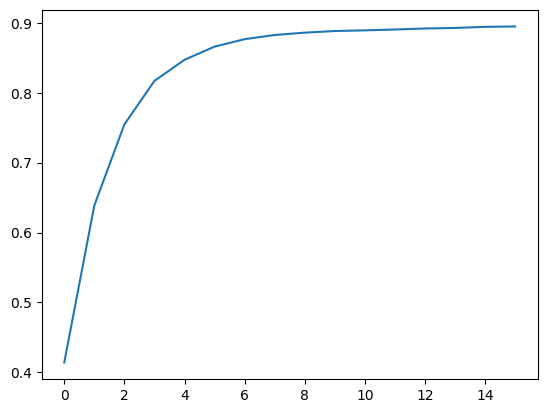

In [177]:
# for XGBoost, remember scores here outputed from xgb.cv is from every boosted rounds
models["XGBoost"] = xgb.XGBRegressor(random_state=18)
start_time = time.time()
dtrain = xgb.DMatrix(X, Y)
params = models["XGBoost"].get_xgb_params()
print(params)
cv_results = xgb.cv(params = params, dtrain = dtrain, nfold = 10, stratified = False, custom_metric = r2_metric, as_pandas = True, seed = 42, num_boost_round = 16)
end_time = time.time()
execution_time = end_time - start_time
scores = cv_results["test-r2-mean"]
print("=="*30)
print("XGBoostRegressor")
print(scores)
print(f"Mean Score: {scores[len(scores) - 1]}")
scores_k10.append(scores[len(scores) - 1])
times_k10.append(execution_time)
print(f"Model training time: {execution_time} seconds")
plt.plot(scores)
plt.show()

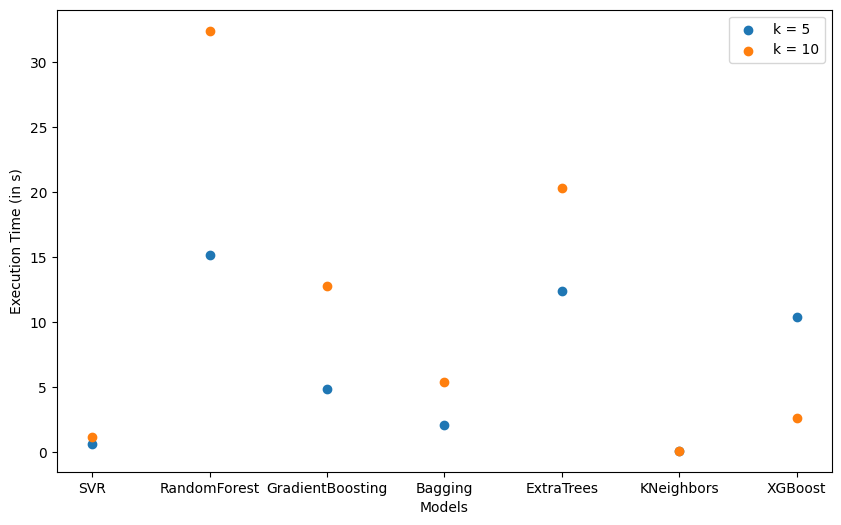

In [178]:
# plotting time comparison between nfolds = 5 and nfolds = 10 for all models in one plot appropriately sizing x an y labels so that they do not overlap
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), times_k5)
plt.scatter(models.keys(), times_k10)
plt.legend(["k = 5", "k = 10"])
plt.xlabel("Models")
plt.ylabel("Execution Time (in s)")
plt.show()

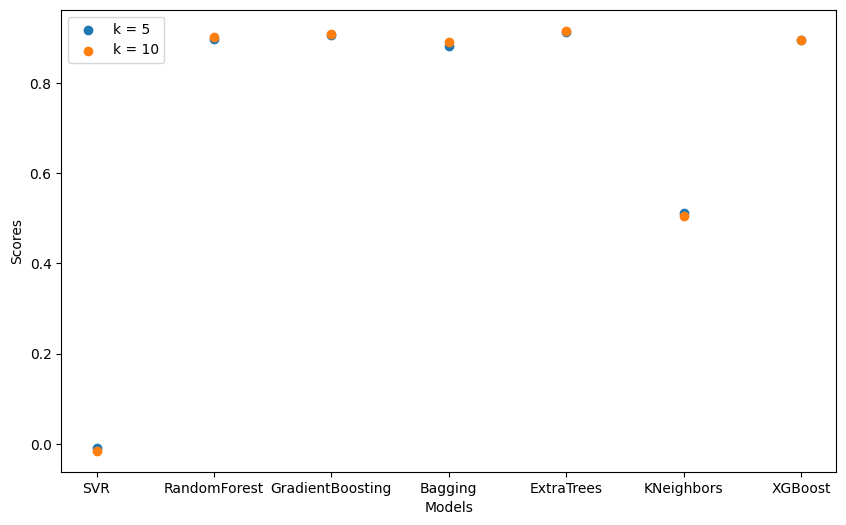

In [179]:
# plotting scores comparison between nfolds = 5 and nfolds = 10 for all models in one plot appropriately sizing x an y labels so that they do not overlap
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), scores_k5)
plt.scatter(models.keys(), scores_k10)
plt.legend(["k = 5", "k = 10"])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.show()

For k = 10, based on cross_val_score and runtime on the entire training dataset, top 5 performing models remain the same as that obtained for k = 5, however the training time doubles and almost no increase in scores is observed.

So we keep k = 5 for further analysis